# Convert Picture into netCDF

## Open Picture

source: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

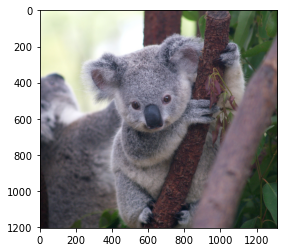

In [1]:

from matplotlib import image
from matplotlib import pyplot
import numpy as np
# load image as pixel array
image = image.imread('Cutest_Koala.jpg')
# summarize shape of the pixel array
## print(image.dtype)
## print(image.shape)
# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()
# image in grey-scales
image_gray = np.mean(image, axis = 2)[:,0:-1]
## print(image_gray.dtype)
## print(image_gray.shape)
# display the array of pixels as an image
## pyplot.imshow(image_gray, cmap='gray')
## pyplot.show()

## Process picture data

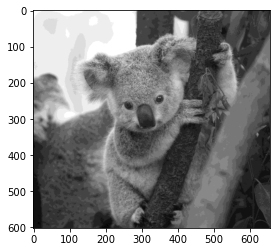

In [2]:
# reduce resolution
fx = 2
fy = 2
fc = 16
image_gray_reduced = (np.mean(image_gray.reshape(int(image_gray.shape[0]/fy), fy, int(image_gray.shape[1]/fx), fx), axis = (1,3)) / fc).astype(np.uint8) * fc
# test
pyplot.imshow(image_gray_reduced, cmap='gray')

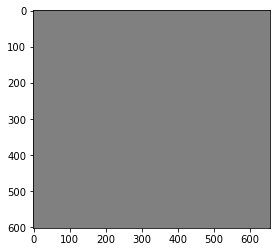

In [3]:
# modify array a bit
image_gray_mod = np.flip(image_gray_reduced, axis=0)
image_gray_mod = image_gray_mod.astype(np.uint16)  + 2**15
# image_gray_mod = image_gray_mod / 16 + 2**6
image_gray_mod[0,0] = 2**16-1
image_gray_mod[-1,-1] = 0
# display the array of pixels as an image
pyplot.imshow(image_gray_mod, cmap='gray')
pyplot.show()

In [4]:
# calculate 20 random numbers per pixel (vertical dimension)
image_gray_vert = np.random.rand(5, image_gray_mod.shape[0], image_gray_mod.shape[1])
image_gray_vert.shape

# function to "normalize" each column so that the sum of this column is 1
def bring_to_sum_one(values):
    return values / np.mean(values)

# call the defined function for each column
image_gray_vert = np.apply_along_axis(bring_to_sum_one, 0, image_gray_vert)

# multiply each column by gray-value
image_gray_vert = image_gray_vert * image_gray_mod

In [5]:
# check processing of image
image_gray_check = np.mean(image_gray_vert, axis = 0)
image_gray_check = image_gray_check%256
## pyplot.imshow(image_gray_check, cmap='gray')

In [6]:
image = None
image_gray = None
image_gray_reduced = None
image_gray_mod = None
image_gray_check = None

## Create netCDF file

In [7]:
# load image_grayfrom netCDF4 import Dataset
import os
from cf_units import Unit
from netCDF4 import Dataset
import datetime

In [8]:
# some constants
filename = "Cutest_Koala.nc"
xlen = image_gray_vert.shape[2]
ylen = image_gray_vert.shape[1]
zlen = image_gray_vert.shape[0]
lon = 9.4448
lat = 53.5952
weight = 3000.0
height = 50.0 # cm
ref_time = "seconds since 2000-01-01 12:00:00"
s_now = Unit("seconds since 2020-07-24 23:02")
s_ref = Unit(ref_time)
time = s_now.convert(0, s_ref)

In [9]:
# create netCDF4 file
if os.path.isfile(filename):
    os.remove(filename)
ncid = Dataset(filename, "w", format="NETCDF4")

In [10]:
# create dimensions
ncid.createDimension('x', xlen)
ncid.createDimension('y', ylen)
ncid.createDimension('z', zlen)
ncid.createDimension('lon', 1)
ncid.createDimension('lat', 1)
ncid.createDimension('height', 1)
ncid.createDimension('time', None)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0

In [11]:
# create axes
## x axis
var_x = ncid.createVariable('x', 'f4', ('x'))
var_x.standard_name = "projection_x_coordinate"
var_x.units = "m"
var_x[:] = np.arange(0, xlen)/(xlen-1)
## y axis
var_y = ncid.createVariable('y', 'f4', ('y'))
var_y.standard_name = "projection_y_coordinate"
var_y.units = "m"
var_y[:] = np.arange(0, ylen)/(ylen-1)
## z axis
var_z = ncid.createVariable('z', 'f4', ('z'))
var_z.standard_name = "height"
var_z.units = "m"
var_z.positive = "up"
var_z[:] = np.arange(0, zlen)/(zlen-1)
## lon
var_lon = ncid.createVariable('lon', 'f4', ('lon'))
var_lon.standard_name = "longitude"
var_lon.units = "degrees_east"
var_lon[:] = lon
## lon
var_lat = ncid.createVariable('lat', 'f4', ('lat'))
var_lat.standard_name = "latitude"
var_lat.units = "degrees_north"
var_lat[:] = lat
## height
var_height = ncid.createVariable('height', 'f4', ('height'))
var_height.standard_name = "height"
var_height.units = "m"
var_height.positive = "up"
var_height[:] = height
## time axis
var_time = ncid.createVariable('time', 'f8', ('time'))
var_time.standard_name = 'time'
var_time.units = ref_time
var_time.calendar = 'gregorian'
var_time[:] = time

In [12]:
# create data variable
## weight
var_w = ncid.createVariable('weight', 'f4', ('time', 'height', 'lat', 'lon'))
var_w.long_name = 'baby_mass'
var_w.units = 'kg'
var_w[:] = weight

In [13]:
# create data variable
## weight
var_t = ncid.createVariable('ta', 'f4', ('time', 'height', 'lat', 'lon'))
var_t.long_name = 'indoor air temperature'
var_t.standard_name = 'air_temperature'
var_t.comment = "This variable was added because the Reading CF Checker complained that no CF-Compliant data variable was found. This is an approximate value (+/- 5K)."
var_t.units = 'K'
var_t[:] = 294

In [14]:
# create data variable
## picture
var_pic = ncid.createVariable('picture', 'f4', ('time', 'z', 'y', 'x'), zlib=True, complevel=2)
var_pic.long_name = 'a_picture'
var_pic.units = "1"
var_pic[0,:,:,:] = image_gray_vert.astype(np.float)

In [15]:
# create global attributes
ncid.Conventions = "CF-1.7"
ncid.creator = "Erik Veland"
ncid.publisher = "Daniel Heydebreck"
ncid.keywords = "Koala, Cute, Animal"
ncid.title = "Baby koala, captured at Currumbin Wildlife Sanctuary"
ncid.summary = "This it the picture of a very cute koala"
ncid.history = str(datetime.datetime.now(tz=None)) + " created via python3 using matplotlib, netCDF4, datetime, cf_units, numpy and os\n2006-02-26 photo taken by Erik Veland"
ncid.id = "https://upload.wikimedia.org/wikipedia/commons/2/21/Cutest_Koala.jpg"
ncid.license = "CC BY-SA 3.0"

In [16]:
# close netCDF4 file
ncid.close()